# 🚘 Previsão do Preço de Carros Usados

# Importações

O objetivo desse projeto é fazer a previsão do preço de carros usados utilizando regressão com os dados do dataset `cars` fornecido pelo programa de bolsas, além disso, estarei utilizando as seguintes bibliotecas:

In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [88]:
from sklearn.preprocessing import LabelEncoder
import category_encoders as ce
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import shap

# Importações para teste:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor

In [3]:
dataset = pd.read_csv('../data/cars.csv')

# Visualização dos Dados e Processo de Amostragem

In [4]:
dataset.shape

(762091, 20)

In [5]:
dataset.head(3)

,manufacturer,model,year,mileage,engine,transmission,drivetrain,fuel_type,mpg,exterior_color,interior_color,accidents_or_damage,one_owner,personal_use_only,seller_name,seller_rating,driver_rating,driver_reviews_num,price_drop,price
0,Acura,ILX Hybrid 1.5L,2013,92945.0,"1.5L I-4 i-VTEC variable valve control, engine...",Automatic,Front-wheel Drive,Gasoline,39-38,Black,Parchment,0.0,0.0,0.0,Iconic Coach,NaN,4.4,12.0,300.0,13988.0
1,Acura,ILX Hybrid 1.5L,2013,47645.0,1.5L I4 8V MPFI SOHC Hybrid,Automatic CVT,Front-wheel Drive,Hybrid,39-38,Gray,Ebony,1.0,1.0,1.0,Kars Today,NaN,4.4,12.0,NaN,17995.0
2,Acura,ILX Hybrid 1.5L,2013,53422.0,1.5L I4 8V MPFI SOHC Hybrid,Automatic CVT,Front-wheel Drive,Hybrid,39-38,Bellanova White Pearl,Ebony,0.0,1.0,1.0,Weiss Toyota of South County,4.3,4.4,12.0,500.0,17000.0


Como orientado nas instruções desse projeto, será necessário gerar uma amostra aleatória reprodutível de *25%* do dataset acima. (Cerca de 190 mil registros). Dessa forma, foi gerado através do método sample(), passando o random_state como parâmetro para obter uma amostra que seja reprodutível.

In [6]:
base_cars = dataset.sample(frac=0.25, random_state=13)

In [7]:
base_cars.shape

(190523, 20)

In [8]:
base_cars.head()

,manufacturer,model,year,mileage,engine,transmission,drivetrain,fuel_type,mpg,exterior_color,interior_color,accidents_or_damage,one_owner,personal_use_only,seller_name,seller_rating,driver_rating,driver_reviews_num,price_drop,price
357596,Hyundai,Santa Fe SE 2.4,2020,50424.0,2.4L I4 16V GDI DOHC,8-Speed Automatic,Front-wheel Drive,Gasoline,22-29,Scarlet Red,Black,0.0,1.0,0.0,ALM Kia South,4.1,4.8,207.0,NaN,21977.0
521642,Mercedes-Benz,E-Class E 350,2021,20534.0,2.0L I4 16V GDI DOHC Turbo,9-Speed Automatic,Rear-wheel Drive,Gasoline,22-31,Silver,Black,0.0,1.0,1.0,Mercedes-Benz of South Orlando,4.5,4.7,7.0,NaN,44899.0
608658,Porsche,Cayenne Platinum Edition,2022,6036.0,3.0L V6 24V GDI DOHC Turbo,8-Speed Automatic,All-wheel Drive,Gasoline,19-23,White,Slate Gray,0.0,1.0,1.0,Land Rover Richfield,4.2,NaN,0.0,1000.0,79599.0
121443,Chevrolet,Trax,2020,35422.0,NaN,NaN,NaN,NaN,NaN,Black,NaN,0.0,1.0,0.0,Dick Genthe Chevrolet,3.8,4.5,105.0,NaN,25000.0
349323,Hyundai,Sonata SEL,2021,30913.0,2.5L I4 16V PDI DOHC,8-Speed Automatic,Front-wheel Drive,Gasoline,27-37,Portofino Gray,Black,0.0,1.0,1.0,Luther Bloomington Hyundai,4.6,4.8,46.0,NaN,24000.0


# Análise Exploratória dos Dados (EDA)

## Estatística Descritiva

Inicialmente, comecei pela estatística descritiva, uma vez que é uma parte da análise que será de grande ajuda para entender as variáveis numéricas presentes no dataset. Dessa forma, através do método describe() e de gráficos como Boxplot e Histogramas, estarei fazendo a análise dessas variáveis em questão, obtendo também insights sobre a distribuição desses atributos.

In [9]:
base_cars.describe()

,year,mileage,accidents_or_damage,one_owner,personal_use_only,seller_rating,driver_rating,driver_reviews_num,price_drop,price
count,190523.000000,190407.000000,184467.000000,182731.000000,184312.000000,136927.000000,182629.000000,190523.000000,102454.000000,1.905230e+05
mean,2017.802575,55735.631384,0.228789,0.562526,0.657440,4.157785,4.623162,89.474147,1002.304654,3.777299e+04
std,5.093321,43581.307496,0.420054,0.496076,0.474567,0.807241,0.278138,114.712896,1358.620284,2.291050e+06
min,1915.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,100.000000,2.990000e+02
25%,2016.000000,23345.000000,0.000000,0.000000,0.000000,3.800000,4.500000,14.000000,378.000000,1.959900e+04
50%,2019.000000,45544.000000,0.000000,1.000000,1.000000,4.500000,4.700000,51.000000,633.000000,2.799500e+04
75%,2021.000000,78265.500000,0.000000,1.000000,1.000000,4.700000,4.800000,119.000000,1004.000000,3.955000e+04
max,2024.000000,999999.000000,1.000000,1.000000,1.000000,5.000000,5.000000,1025.000000,90000.000000,1.000000e+09


Alguns pontos importantes a serem analisados sobre a variável objetivo `price`:
 - Média dos preços: 37.772,99
 - Valor máximo: 1.000.000.000,00
 - Valor mínimo: 299,00

 Obs.: Esse valor máximo de 1.000.000.000,00 é uma anomalia (outlier), uma vez que não faz sentido existir um carro que custa 1 bilhão, esse registro será removido posteriormente.

<Axes: ylabel='price'>

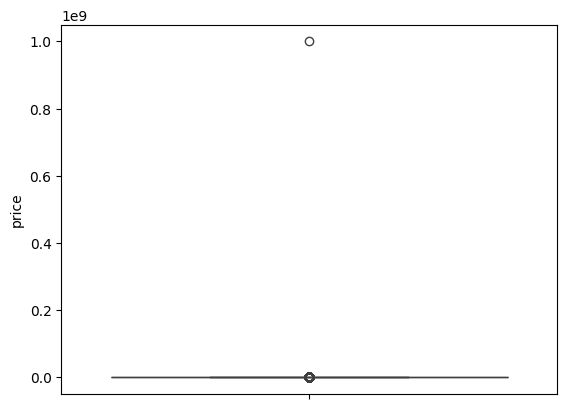

In [10]:
# Gerando o Boxplot para identificar outliers
sns.boxplot(base_cars['price'])

Como mencionado acima, o valor de 1 bilhão aparece no gráfico como um outlier, esse valor será *removido* e será gerado um novo gráfico Boxplot para verificar a ocorrência de novos outliers com a nova distribuição (e escala sem o outlier). 

In [11]:
# Encontrando o valor máximo de 1B e removendo ele
max_price = base_cars['price'].max()
base_cars = base_cars[base_cars['price'] < max_price]

<Axes: ylabel='price'>

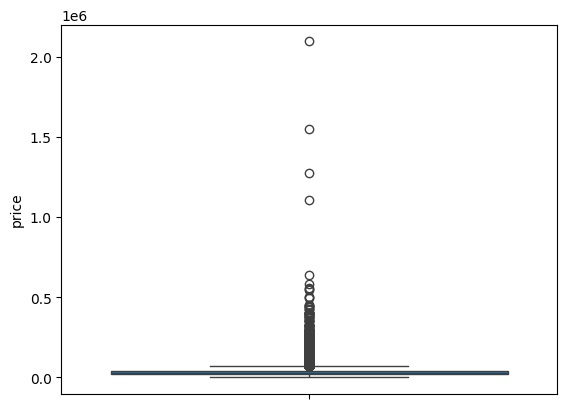

In [12]:
# Gerando o Boxplot para identificar outliers
sns.boxplot(base_cars['price'])

- Limite Superior = 69.475,00
- Limite Inferior = 299,00

Valores acima do limite superior e abaixo do inferior são considerados outliers, segundo o gráfico.

In [13]:
# Verificando os quatro outliers mais notáveis
high_outliers_price = base_cars[base_cars['price'] > 800000]
high_outliers_price


,manufacturer,model,year,mileage,engine,transmission,drivetrain,fuel_type,mpg,exterior_color,interior_color,accidents_or_damage,one_owner,personal_use_only,seller_name,seller_rating,driver_rating,driver_reviews_num,price_drop,price
613079,Porsche,Carrera GT Base (M6),2004,4376.0,5.7L V10 40V MPFI DOHC,6-Speed Manual,Rear-wheel Drive,Gasoline,10-16,GT Silver Metallic,Brown,0.0,0.0,1.0,Porsche North Houston,4.8,4.3,2.0,NaN,1549991.0
213658,Ford,GT,2019,255.0,3.5L V6 Twin Turbo,7-Speed DCT Automatic,NaN,Gasoline,NaN,Red,NaN,0.0,0.0,0.0,Marino Performance Motors,NaN,NaN,0.0,15000.0,1275000.0
91190,Cadillac,DTS,2006,158021.0,4.6L V8 32V MPFI DOHC,4-Speed Automatic with Overdrive,Front-wheel Drive,Gasoline,NaN,Radiant Bronze,NaN,0.0,0.0,1.0,Greve Chrysler Dodge Jeep RAM,3.4,4.6,79.0,NaN,1111111.0
609009,Porsche,918 Spyder Base (PDK),2015,2622.0,4.6L V8 32V GDI DOHC Hybrid,7-Speed Automatic with Auto-Shift,All-wheel Drive,Hybrid,20-24,Black,NaN,0.0,0.0,1.0,Graham Rahal Performance,NaN,3.9,5.0,5000.0,2099995.0


Analisando o contexto e pesquisando os valores dos carros do dataframe acima, é possível aferir que os preços estão de acordo e não irei considerar como um outlier, com exceção do Cadillac DTS 2006 que provavelmente teve seu preço preenchido errado, uma vez que o preço médio dele é bem menor.

In [14]:
# Removendo outlier Cadillac
outlier_value = 1111111
outlier_index = base_cars[base_cars['price'] == outlier_value].index
base_cars = base_cars.drop(outlier_index)

<Axes: ylabel='price_drop'>

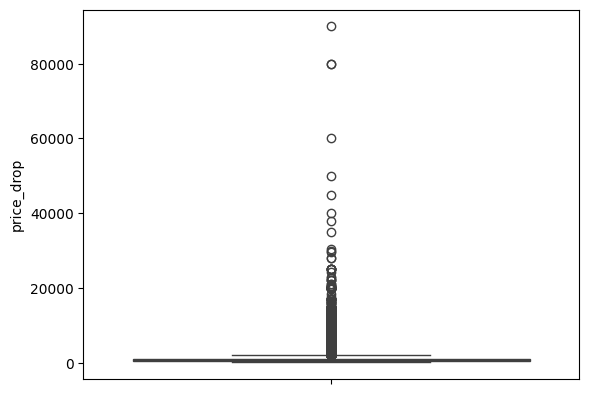

In [15]:
# Gerando Boxplot para identificar outliers em price_drop
sns.boxplot(base_cars['price_drop'])

- Limite Superior = 1943,00
- Limite Inferior = 100,00

In [16]:
# Verificando os outliers mais notáveis
high_outliers_price_drop = base_cars[base_cars['price_drop'] > 40000]
high_outliers_price_drop

,manufacturer,model,year,mileage,engine,transmission,drivetrain,fuel_type,mpg,exterior_color,interior_color,accidents_or_damage,one_owner,personal_use_only,seller_name,seller_rating,driver_rating,driver_reviews_num,price_drop,price
9390,Audi,R8 5.2 quattro,2012,50681.0,5.2L V10 40V GDI DOHC,6-Speed Automatic with Auto-Shift,All-wheel Drive,Gasoline,13-19,NaN,NaN,0.0,0.0,1.0,Carrio Motor Cars,2.1,4.8,16.0,60000.0,89998.0
616082,Porsche,911 Carrera,2021,13788.0,3.0L H6 24V GDI DOHC Twin Turbo,8-Speed Automatic with Auto-Shift,Rear-wheel Drive,Gasoline,18-24,Jet Black Metallic,Slate Gray,0.0,1.0,1.0,Ferrari of Naples,4.0,4.9,4.0,79909.0,119992.0
517552,Mercedes-Benz,AMG GT BS,2021,17.0,4.0L V8 32V GDI DOHC Twin Turbo,7-Speed Automatic with Auto-Shift,Rear-wheel Drive,Gasoline,15-20,Orange,Black,0.0,1.0,0.0,AE of Miami,4.6,NaN,0.0,50000.0,379950.0
269557,Ford,Shelby GT500 Base,2022,900.0,5.2L V8 32V MPFI DOHC Supercharged,7-Speed Automatic with Auto-Shift,Rear-wheel Drive,Gasoline,12-18,Shadow Black,Ebony,0.0,1.0,1.0,Lapin Motor Company,NaN,NaN,0.0,45000.0,127991.0
614482,Porsche,911 Carrera GTS,2022,4120.0,3.0L H6 24V GDI DOHC Twin Turbo,8-Speed Automatic with Auto-Shift,Rear-wheel Drive,Gasoline,17-23,Carmine Red,Black,0.0,0.0,1.0,Ferrari of Naples,4.0,4.9,1.0,79909.0,173992.0
614541,Porsche,911 Turbo,1991,47815.0,3.3L H6 24V DOHC Turbo,5-Speed Manual,Rear-wheel Drive,Gasoline,NaN,Red,Beige,0.0,0.0,1.0,Vegas Auto Gallery,4.5,4.2,7.0,90000.0,299800.0


Considerando a variável de *acidentes* ou *danos* e observando que nenhum dos veículos presentes sofreu com isso é de se estranhar uma queda tão grande como de 40k para cima nesses modelos, uma vez que pesquisando observei até mesmo que alguns desses carros tiveram uma recente valorização desde 2021. Dado isso, irei remover os valores acima de 40k de *price_drop* ou a própria coluna *price_drop* dependendo da importância dela.

<Axes: ylabel='mileage'>

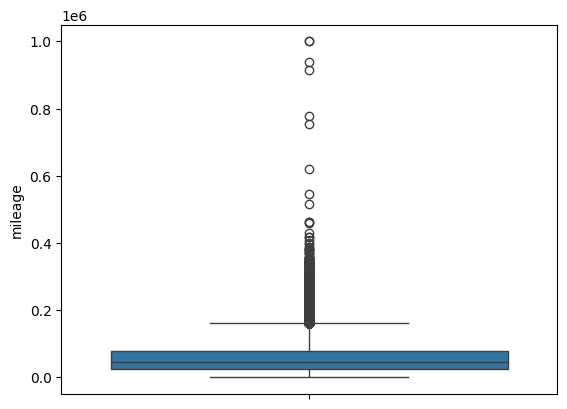

In [17]:
# Gerando Boxplot para identificar outliers em mileage
sns.boxplot(base_cars['mileage'])

- Limite Superior = 160.639
- Limite Inferior = 0

Pode-se observar alguns valores atípicos, como mais de 1 milhão de milhas percorridas.

In [18]:
# Verificando outliers com valores maior que 350 mil milhas
high_outliers_mileage = base_cars[base_cars['mileage'] > 350000]
high_outliers_mileage

,manufacturer,model,year,mileage,engine,transmission,drivetrain,fuel_type,mpg,exterior_color,interior_color,accidents_or_damage,one_owner,personal_use_only,seller_name,seller_rating,driver_rating,driver_reviews_num,price_drop,price
213570,Ford,Excursion Eddie Bauer,2003,351264.0,6.0L V8 32V DDI OHV Turbo Diesel,5-Speed Automatic,Four-wheel Drive,Diesel,NaN,Blue,Tan,0.0,0.0,1.0,Performance Auto Sales Inc,4.4,4.5,28.0,NaN,12977.0
213507,Ford,Excursion Limited,2003,380355.0,6.0L V8 32V DDI OHV Turbo Diesel,5-Speed Automatic,Four-wheel Drive,Diesel,NaN,Black,NaN,1.0,0.0,0.0,Vehicle City Motors,2.9,4.5,28.0,1955.0,11950.0
220225,Ford,Transit-350 XL,2016,620637.0,3.7L V6 24V MPFI DOHC,6-Speed Automatic,Rear-wheel Drive,NaN,NaN,Oxford White,Pewter,1.0,1.0,1.0,Cornhusker Nissan of Norfolk,NaN,4.3,22.0,NaN,39990.0
726683,Toyota,Tundra Limited,2013,353788.0,5.7L V8 32V MPFI DOHC,6-Speed Automatic,Four-wheel Drive,Gasoline,13-17,Black,Sand Beige,0.0,0.0,0.0,Wilson Toyota of Ames,4.6,4.6,79.0,NaN,14900.0
136605,Chevrolet,Silverado 3500 Work Truck Crew Cab,2009,358192.0,6.6L V8 32V DDI OHV Turbo Diesel,6-Speed Automatic,Four-wheel Drive,Diesel,NaN,Summit White,Dark Titanium,1.0,0.0,1.0,Mike Alsop Chevrolet,4.5,4.6,3.0,464.0,14500.0
250232,Ford,F-450 Duty,2016,355518.0,Engine: 6.8L 3-Valve SOHC EFI V10 Balanced out...,Automatic,Four-wheel Drive,Gasoline,0-0,White,Gray,1.0,1.0,0.0,Your Choice Autos Waukegan,4.2,4.8,3.0,NaN,9499.0
522994,Mercedes-Benz,E-Class E 350 4MATIC,2021,915383.0,2.0L I4 16V GDI DOHC Turbo,9-Speed Automatic,All-wheel Drive,Gasoline,22-30,Polar White,Macchiato Beige,0.0,0.0,0.0,Mercedes-Benz of Wesley Chapel,4.5,4.7,7.0,500.0,53539.0
520366,Mercedes-Benz,Sprinter 2500 High Roof,2020,350181.0,"3L V-6 diesel direct injection, DOHC, intercoo...",Automatic,Rear-wheel Drive,Diesel,0-0,White,Black,1.0,1.0,1.0,Modus Auto Group,NaN,NaN,0.0,500.0,32495.0
682799,Toyota,4Runner SR5,2006,357000.0,236.0HP 4.0L V6 Cylinder Engine Gasoline Fuel,A/T,Rear-wheel Drive,Gasoline,NaN,Black,NaN,NaN,NaN,NaN,NaN,NaN,4.7,105.0,NaN,6000.0
70583,Buick,Lucerne CXL,2006,397831.0,3.8L V6 12V MPFI OHV,4-Speed Automatic,Front-wheel Drive,Gasoline,19-28,Dark Granite Metallic,Cashmere,1.0,0.0,1.0,Corwin Public Wholesale,4.5,4.5,51.0,NaN,2500.0


Pesquisando sobre a média de quilometragem dos modelos acima, verifiquei que a maioria tem valores atípicos e alguns com certeza são erros de digitação como o Lincoln Continental. Com o objetivo de também não enviezar o modelo e tornar sua performance melhor, optei por remover esses valores.

In [19]:
# Removendo carros com mais de 350 mil milhas
outlier_mileage = 350000
base_cars = base_cars[base_cars['mileage'] < outlier_mileage]

<Axes: ylabel='mileage'>

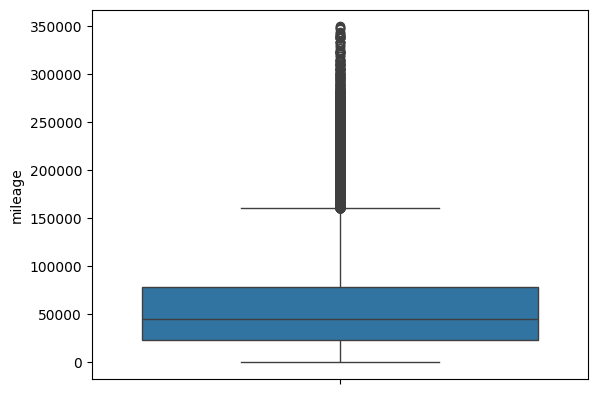

In [20]:
# Gerando Boxplot após remoção
sns.boxplot(base_cars['mileage'])

In [21]:
# Traçando um limite para melhorar a visualização
limit_price = base_cars[base_cars['price'] < 200000]

<Axes: xlabel='price', ylabel='Count'>

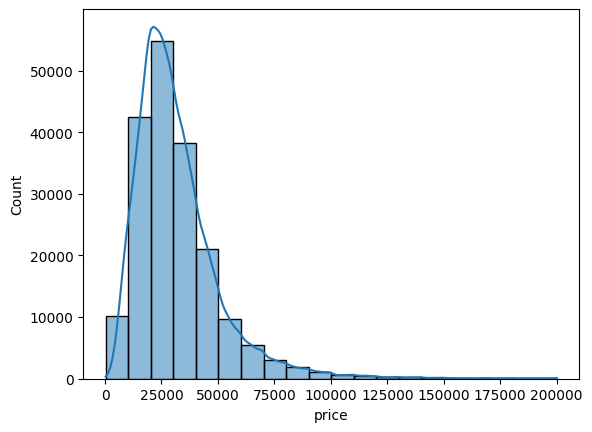

In [22]:
sns.histplot(x=limit_price['price'], kde=True, bins=20)

In [23]:
# Traçando um limite para melhorar a visualização do price_drop
limit_price_drop = base_cars[base_cars['price_drop'] < 13000]

<Axes: xlabel='price_drop', ylabel='Count'>

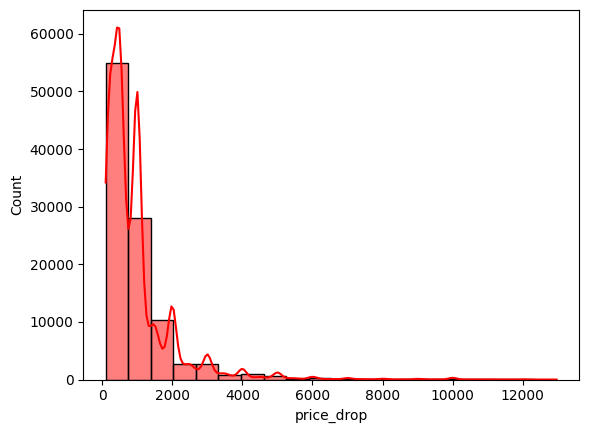

In [24]:
sns.histplot(x=limit_price_drop['price_drop'], kde=True, color='red', bins=20)

<Axes: xlabel='year', ylabel='Count'>

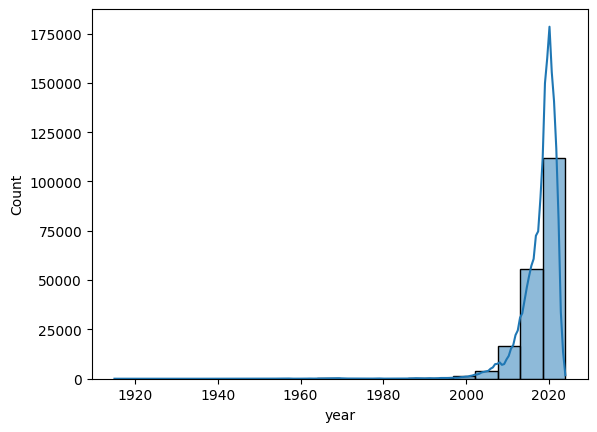

In [25]:
# Gerando Histograma da variável year
sns.histplot(x=base_cars['year'], kde=True, bins=20)

In [26]:
# Traçando limite para melhorar a visualização do mileage
limit_mileage = base_cars[base_cars['mileage'] < 400000]

<Axes: xlabel='mileage', ylabel='Count'>

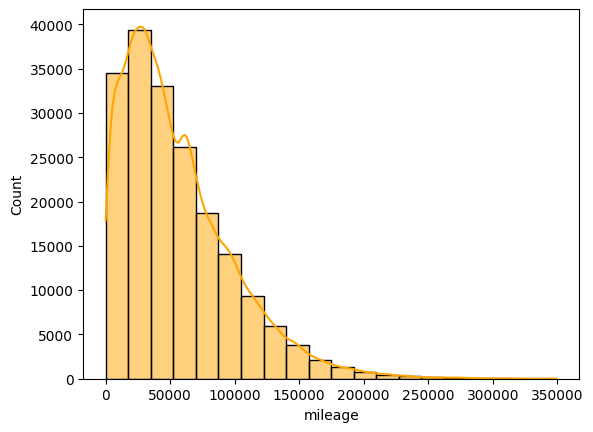

In [27]:
# Gerando Histograma de mileage
sns.histplot(x=limit_mileage['mileage'], kde=True, color='orange', bins=20)

<Axes: xlabel='seller_rating', ylabel='Count'>

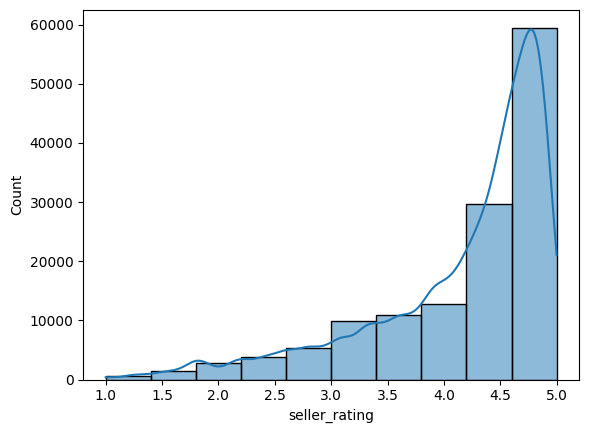

In [28]:
# Gerando Histograma de seller_rating
sns.histplot(base_cars['seller_rating'], bins=10, kde=True)

<Axes: xlabel='driver_rating', ylabel='Count'>

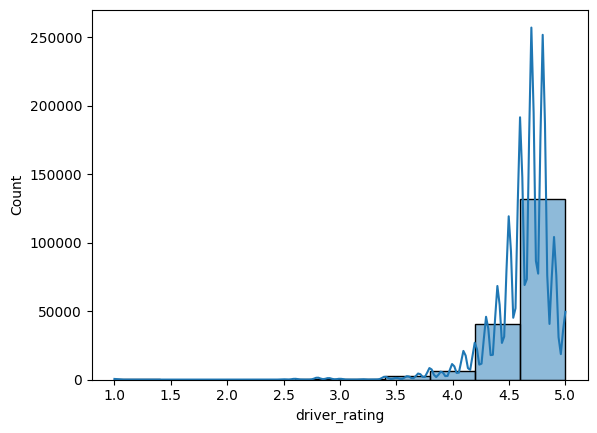

In [29]:
# Gerando Histograma de driver_rating
sns.histplot(base_cars['driver_rating'], bins=10, kde=True)

<Axes: xlabel='driver_reviews_num', ylabel='Count'>

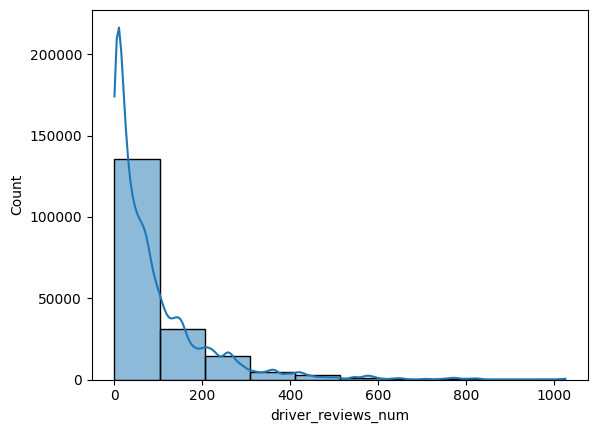

In [30]:
# Gerando Histograma de driver_reviews_num
sns.histplot(base_cars['driver_reviews_num'], bins=10, kde=True)

## Analisando Variáveis Categóricas

Após a análise da estatística descritiva, na qual foi analisado também as variáveis numéricas com Boxplots e Histogramas, agora irei analisar as variáveis categóricas e utilizar CountPlots em algumas para exemplificar visualmente.

<Axes: xlabel='count', ylabel='manufacturer'>

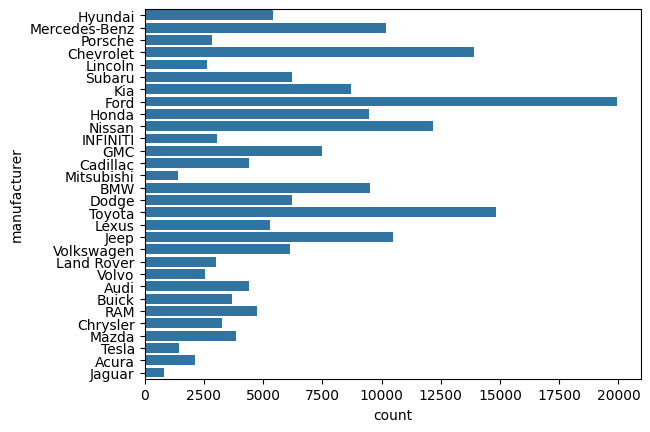

In [32]:
# Gerando countplot das fabricantes
sns.countplot(base_cars['manufacturer'])

In [33]:
model = base_cars.groupby(['model']).size().sort_values(ascending=False)
model

model
Fusion SE                                                  774
Sportage LX                                                732
GLC 300 Base 4MATIC                                        691
Corolla LE                                                 686
Optima LX                                                  650
                                                          ... 
i4 Gran Coupe                                                1
i3 W RANGE EXTENDER, 20 INCH, NEW BATTERIES                  1
i3 W RANGE EXTENDER TERA PKG, TECH AND DRIVER, HK SOUND      1
i3 W RANGE EXTENDER GIGA FULLY LOADED                        1
i3 W RANGE EXTENDER AND MOONROOF                             1
Length: 7903, dtype: int64

Como são muitos modelos, selecionei uma das fabricantes sendo a Jaguar para mostrar os modelos produzidos por ela.

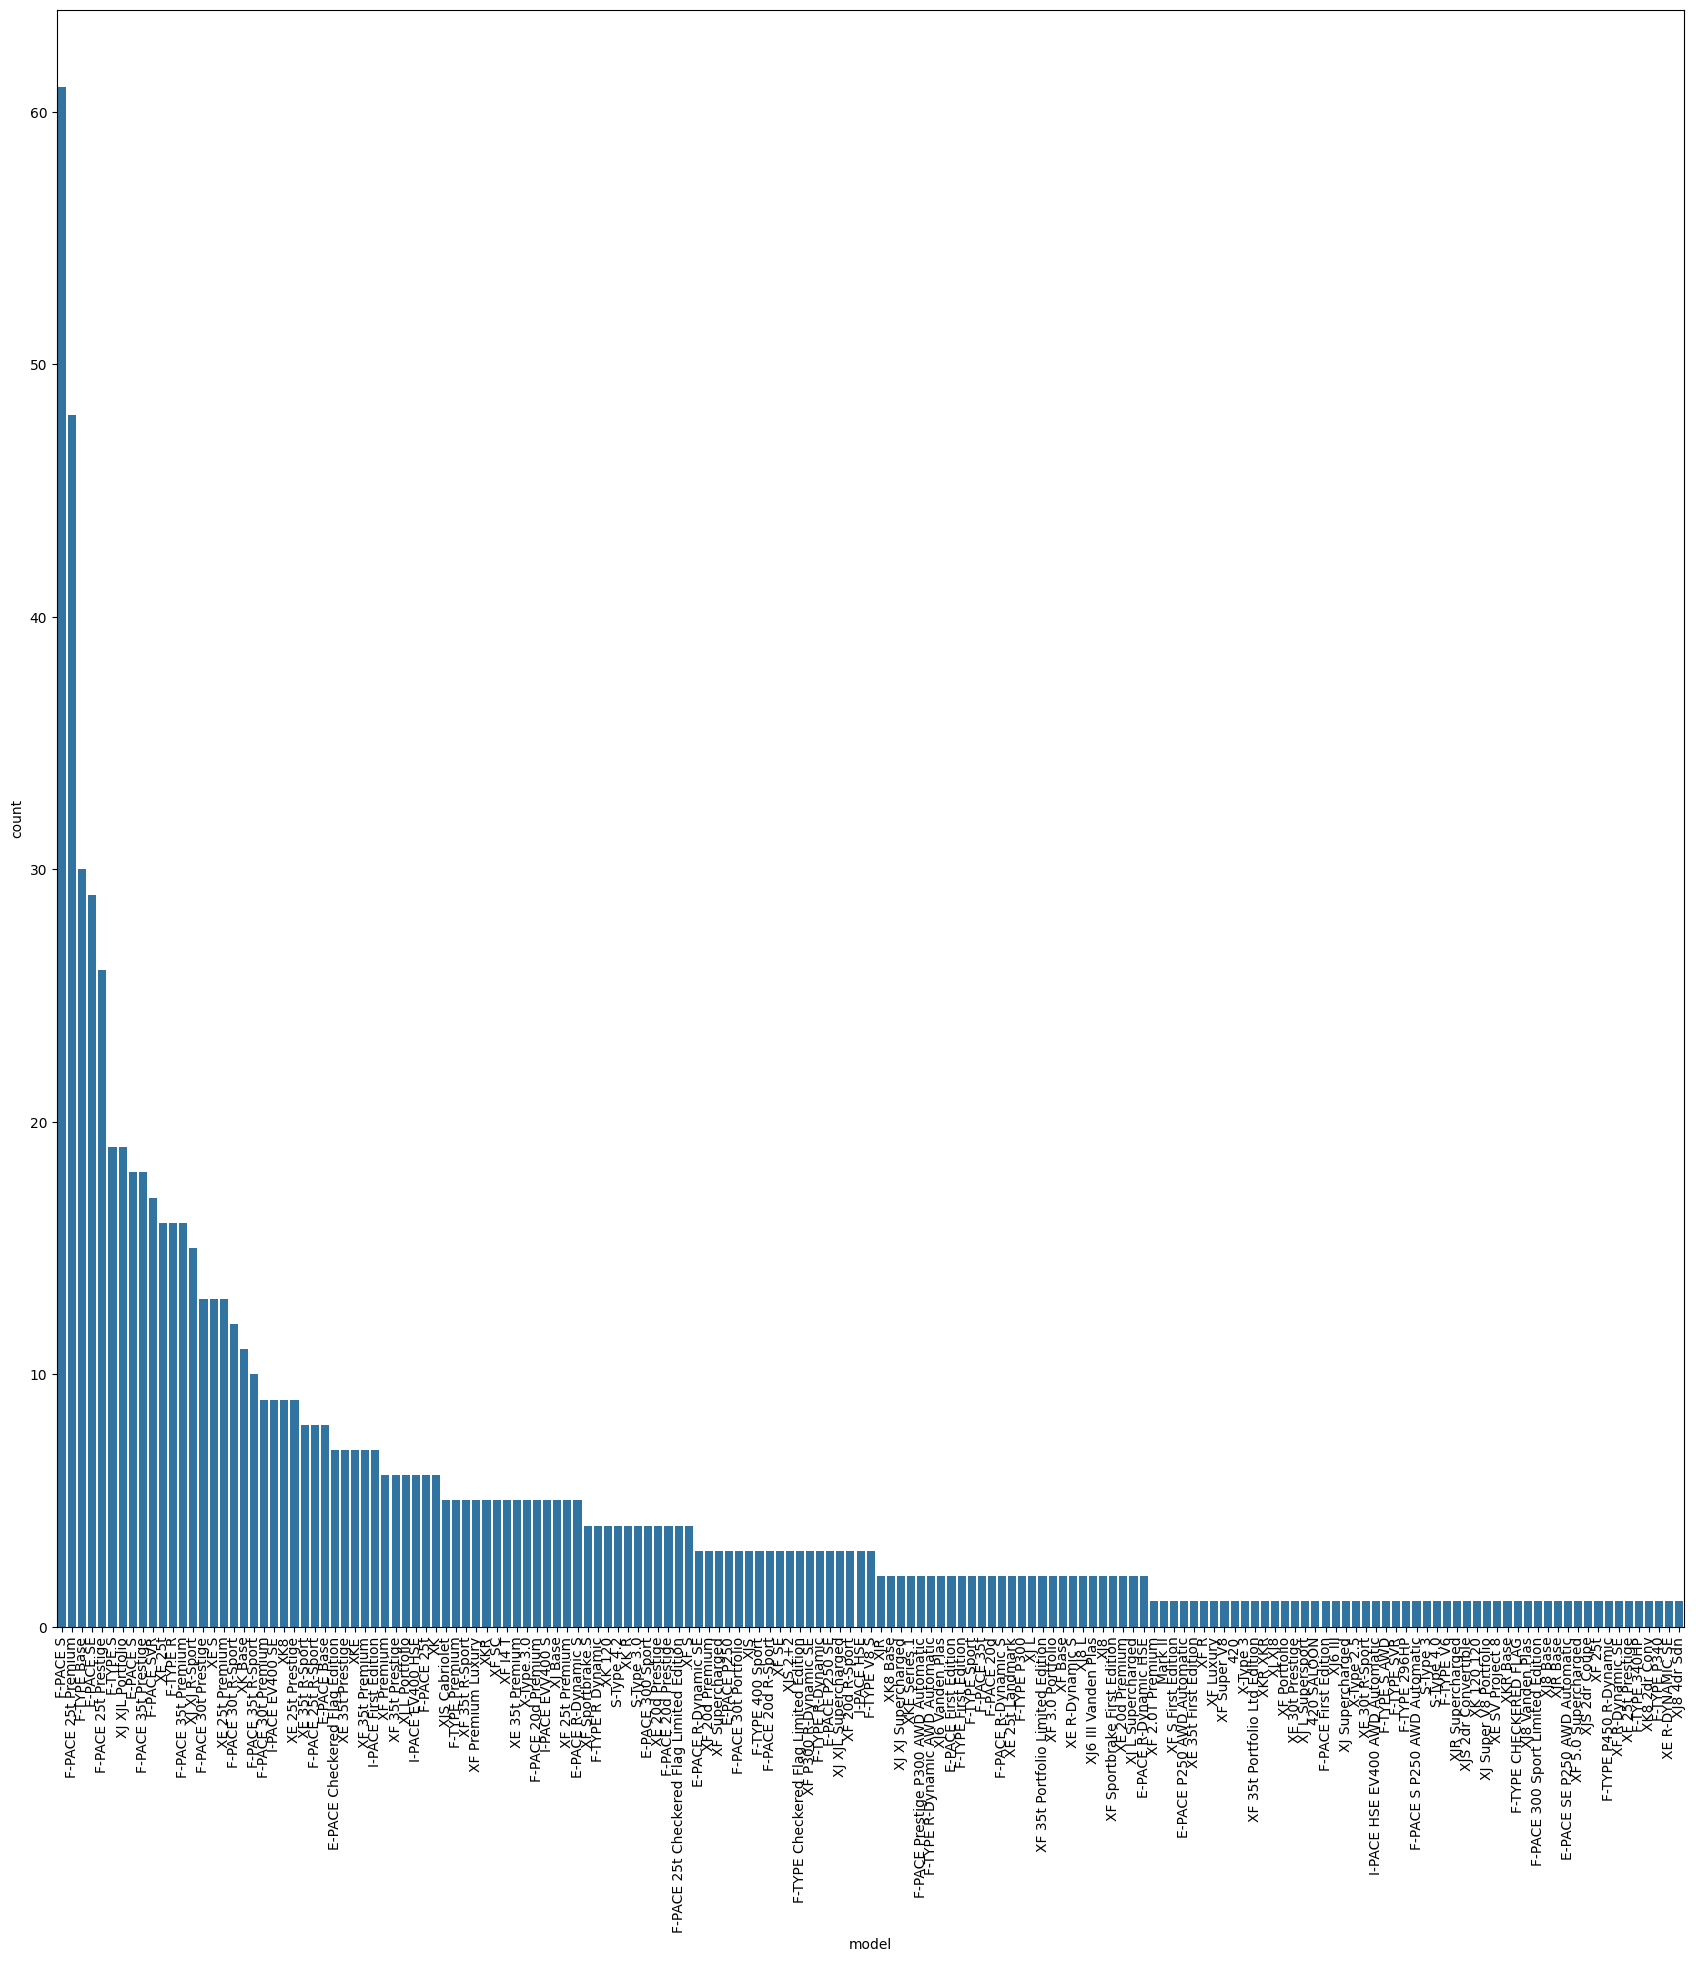

In [34]:
# Gerando gráfico com modelos da Jaguar
plt.figure(figsize=(21,21))
manufacturer = 'Jaguar'
sns.countplot(x='model', data=base_cars[base_cars['manufacturer'] == manufacturer], 
              order=base_cars[base_cars['manufacturer'] == manufacturer]['model'].value_counts().index)
plt.xticks(rotation=90)
plt.show()

In [35]:
engine = base_cars.groupby(['engine']).size().sort_values(ascending=False)
engine

engine
2.0L I4 16V GDI DOHC Turbo           18855
3.6L V6 24V MPFI DOHC                 8994
3.6L V6 24V GDI DOHC                  6967
2.0L I4 16V MPFI DOHC                 4832
1.5L I4 16V GDI DOHC Turbo            4556
                                     ...  
Vortec 8.1L V-8 engine with 340HP        1
Vulcan 3L V-6 engine with 153HP          1
Vulcan 3L V-6 engine with 155HP          1
Weiland Supercharged 350 CID V8          1
ZO6 LS7 427 V8                           1
Length: 3858, dtype: int64

In [36]:
transmission = base_cars.groupby(['transmission']).size().sort_values(ascending=False)
transmission

transmission
6-Speed Automatic                   37298
8-Speed Automatic                   34994
Automatic CVT                       27102
Automatic                           24206
9-Speed Automatic                   15293
                                    ...  
TorqShift 6-Speed Automatic -inc        1
xtronic cvt continuously varia          1
electronically controlled cvt           1
2 Spd Powerglide Automatic              1
2 Speed Manual                          1
Length: 662, dtype: int64

In [37]:
drive_train = base_cars.groupby(['drivetrain']).size().sort_values(ascending=False)
drive_train

drivetrain
Front-wheel Drive                                              60150
All-wheel Drive                                                57803
Four-wheel Drive                                               39330
Rear-wheel Drive                                               24112
FWD                                                             1653
AWD                                                              904
4WD                                                              483
RWD                                                              426
Front-Wheel Drive                                                 39
All-Wheel Drive                                                   38
Unknown                                                           27
Front-Wheel Drive with Limited-Slip Differential                  16
Four-Wheel Drive with Locking and Limited-Slip Differential       13
Four-Wheel Drive                                                  12
All-Wheel Drive with Lo

In [38]:
fuel_type = base_cars.groupby(['fuel_type']).size().sort_values(ascending=False)
fuel_type

fuel_type
Gasoline                         161001
Hybrid                             7346
Diesel                             7025
E85 Flex Fuel                      4705
Electric                           3978
B                                   357
Flexible Fuel                       122
Plug-In Hybrid                       32
Gasoline Fuel                        21
Gasoline/Mild Electric Hybrid        18
Regular Unleaded                     15
Premium Unleaded                     12
Compressed Natural Gas                9
G                                     8
Unspecified                           5
Diesel Fuel                           2
Other                                 2
Hybrid Fuel                           2
Flex Fuel Capability                  1
Bio Diesel                            1
Gas                                   1
Gas/Electric Hybrid                   1
PHEV                                  1
Hydrogen Fuel Cell                    1
dtype: int64

<Axes: xlabel='count', ylabel='fuel_type'>

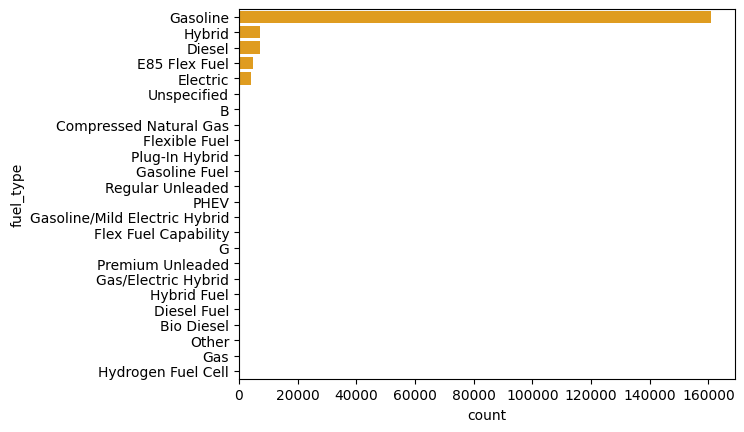

In [39]:
# Gerando o gráfico dos tipos de gasolina
sns.countplot(base_cars['fuel_type'], color='orange')

In [40]:
mpg = base_cars.groupby(['mpg']).size().sort_values(ascending=False)
mpg

mpg
19-26      4065
18-25      3970
17-25      3520
20-27      3310
16-23      2925
           ... 
58-0          1
51-49         1
51-48.0       1
9-7           1
54-0          1
Length: 652, dtype: int64

In [41]:
exterior_color = base_cars.groupby(['exterior_color']).size().sort_values(ascending=False)
exterior_color

exterior_color
Black                                         15081
White                                         12724
Gray                                           7628
Silver                                         5982
Blue                                           4374
                                              ...  
designo? Platinum Magno Matte                     1
designo Selenite Grey Magno (Matte Finish)        1
0221                                              1
0218 / EA10                                       1
01u                                               1
Length: 4691, dtype: int64

In [42]:
interior_color = base_cars.groupby(['interior_color']).size().sort_values(ascending=False)
interior_color

interior_color
Black                                      71773
Gray                                       12422
Jet Black                                  11461
Ebony                                       9505
Charcoal                                    6549
                                           ...  
designo Porcelain/Espresso Brown               1
designo Porcelain/Black Leather Package        1
Jet Black/Cinnamon                             1
Jet Black/Carhartt Brown                       1
silver                                         1
Length: 2645, dtype: int64

In [43]:
accidents_or_damage = base_cars.groupby(['accidents_or_damage']).size()
accidents_or_damage

accidents_or_damage
0.0    142141
1.0     42177
dtype: int64

<Axes: xlabel='accidents_or_damage', ylabel='count'>

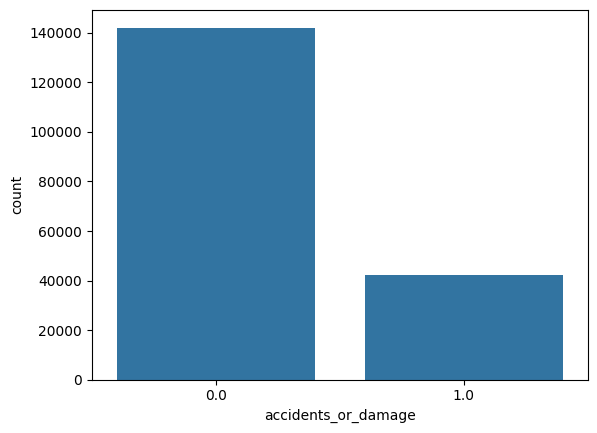

In [44]:
# Gráfico da variável de acidentes ou danos sofridos
sns.countplot(x='accidents_or_damage', data=base_cars)

Segundo o gráfico e análise, a proporção de envolvimento em acidentes é:
 - Não esteve envolvido (0): 142262
 - Esteve envolvido (1): 42204

In [45]:
one_owner = base_cars.groupby(['one_owner']).size()
one_owner

one_owner
0.0     79882
1.0    102722
dtype: int64

<Axes: xlabel='one_owner', ylabel='count'>

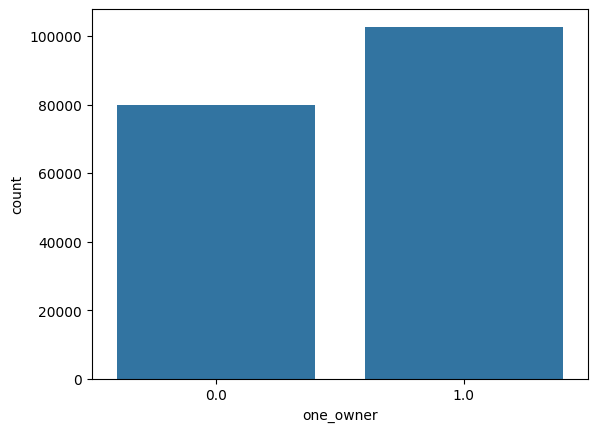

In [46]:
# Gerando gráfico de único dono
sns.countplot(x='one_owner', data=base_cars)

Segundo o gráfico e análise, a proporção de carros que tiveram um único dono:
 - Único dono (1): 102790
 - Mais de um dono (0): 79940

In [47]:
personal_use_only = base_cars.groupby(['personal_use_only']).size()
personal_use_only

personal_use_only
0.0     63076
1.0    121088
dtype: int64

<Axes: xlabel='personal_use_only', ylabel='count'>

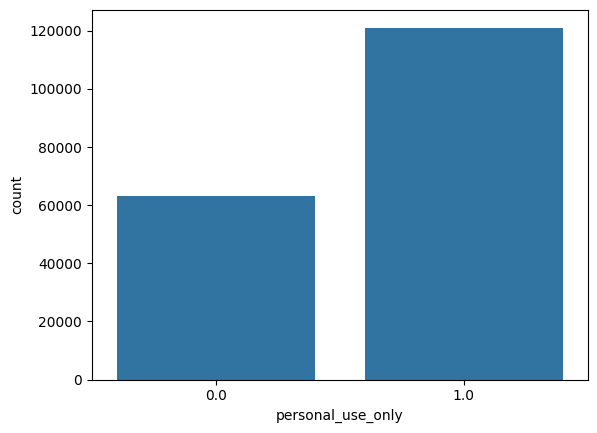

In [48]:
# Gerando gráfico de apenas uso pessoal ou não
sns.countplot(x='personal_use_only', data=base_cars)

Segundo o gráfico e análise, a proporção de carros para apenas uso pessoal:
 - Apenas uso pessoal (1): 121088
 - Outros usos além de pessoal (0): 63076

In [49]:
seller_name = base_cars.groupby(['seller_name']).size().sort_values(ascending=False)
seller_name

seller_name
Gateway Classic Cars                 397
East Coast Auto Source               255
Auto Boutique                        173
Adams North Charlotte                167
Automotive Avenues                   157
                                    ... 
Avenue Auto Group                      1
Avenue Auto                            1
MAZDA OF VALLEY STREAM                 1
MARTHALER AUTOMOTIVE OF MARQUETTE      1
MINI of Towson                         1
Length: 17004, dtype: int64

## Variáveis Numéricas e Categóricas

In [50]:
base_cars.dtypes

manufacturer            object
model                   object
year                     int64
mileage                float64
engine                  object
transmission            object
drivetrain              object
fuel_type               object
mpg                     object
exterior_color          object
interior_color          object
accidents_or_damage    float64
one_owner              float64
personal_use_only      float64
seller_name             object
seller_rating          float64
driver_rating          float64
driver_reviews_num     float64
price_drop             float64
price                  float64
dtype: object

Com base na análise acima das variáveis, bem como o método dtypes que também ajuda a entender como estão classificados os tipos das variáveis, é possível afirmar:

- Atributos categóricos são: `manufacturer`, `model`, `engine`, `transmission`, `drivetrain`, `fuel_type`, `mpg`, `exterior_color`, `interior_color`, `accidents_or_damage`, `one_owner`, `personal_use_only` e `seller_name` pois são variáveis que representam grupos ou categorias.

- Atributos numéricos são: `year`, `mileage`, `seller_rating`, `driver_rating`, `driver_reviews_num`, `price_drop` e `price`.


In [51]:
# Selecionando as variáveis númericas para criar a correlação
base_cars_numerico = base_cars.loc[:, ['year', 'mileage', 'seller_rating', 'driver_rating', 'driver_reviews_num', 'price_drop', 'price']]
base_cars_numerico

,year,mileage,seller_rating,driver_rating,driver_reviews_num,price_drop,price
357596,2020,50424.0,4.1,4.8,207.0,NaN,21977.0
521642,2021,20534.0,4.5,4.7,7.0,NaN,44899.0
608658,2022,6036.0,4.2,NaN,0.0,1000.0,79599.0
121443,2020,35422.0,3.8,4.5,105.0,NaN,25000.0
349323,2021,30913.0,4.6,4.8,46.0,NaN,24000.0
...,...,...,...,...,...,...,...
437032,2017,82724.0,4.0,4.8,460.0,100.0,13300.0
338460,2023,4898.0,4.0,4.0,6.0,NaN,26480.0
80217,2019,11970.0,NaN,4.1,108.0,495.0,34989.0
373708,2001,76915.0,NaN,4.6,10.0,NaN,16500.0


<Axes: >

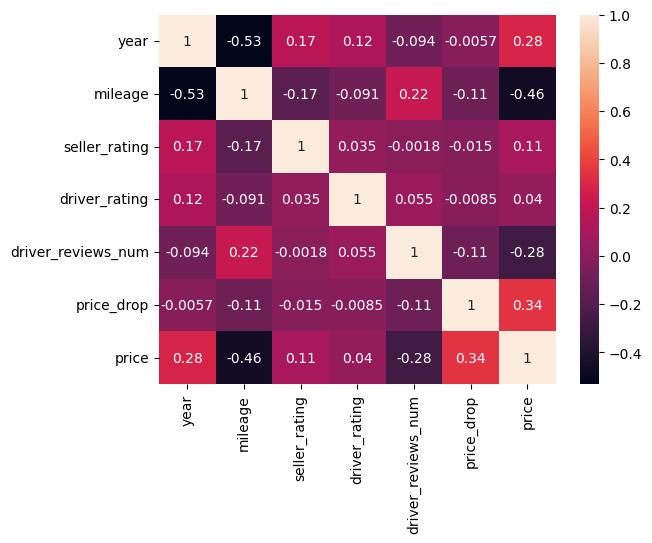

In [52]:
# Representação gráfica da correlação das variáveis numéricas
sns.heatmap(base_cars_numerico.corr(method='pearson'), annot=True)

## Valores Nulos e Duplicados

In [53]:
# Verificando se existe registros duplicados
base_cars.duplicated().sum()

np.int64(588)

In [54]:
# Removendo duplicatas
base_cars.drop_duplicates(inplace=True)
base_cars.shape

(189781, 20)

In [55]:
# Verificando a ocorrência de valores faltantes
base_cars.isnull().sum()

manufacturer               0
model                      0
year                       0
mileage                    0
engine                  3720
transmission            2489
drivetrain              5265
fuel_type               5652
mpg                    35185
exterior_color          2221
interior_color         14124
accidents_or_damage     6009
one_owner               7717
personal_use_only       6162
seller_name             2084
seller_rating          53416
driver_rating           7848
driver_reviews_num         0
price_drop             87620
price                      0
dtype: int64

Antes de tratar esses valores faltantes, realizei alguns testes treinando um modelo com os dados do dataset de `cars` e após isso usei um dos métodos de XAI para verificar a importância das variáveis para o modelo (com diferentes algoritmos de regressão). Abaixo é possível visualizar graficamente os resultados:

<p align="center">
    <img src="./evidencias/shap_dt.png" alt="SHAP VALUES" width="300">
    <img src="./evidencias/shap_rl.png" alt="SHAP VALUES" width="300">
    <img src="./evidencias/shap_rf.png" alt="SHAP VALUES" width="300">
</p>

Baseado nisso, estarei escolhendo oito das 19 variáveis (previsores) e, logo, fazendo o tratamento de dados nulos apenas dessas oito variáveis. Elas são: `mpg`, `mileage`, `year`, `engine`, `driver_reviews_num`, `manufacturer`, `model` e `drivetrain`.

# Pré Processamento dos Dados

## Tratamento de Valores Faltantes

Para fazer o tratamento dos valores faltantes de `mpg` e `drivetrain` optei por preencher os valores através da proporção da ocorrência desses valores de acordo com o modelo do carro.

In [56]:
# Buscando os valores únicos da variável 'model'
cars_models = base_cars['model'].unique()

In [57]:
# Tratando os valores nulos de mpg de acordo com a distruibuição em cada modelo
for model in cars_models:
  conditional = base_cars[base_cars['model'] == model]['mpg'].value_counts(normalize=True)
  missing_values = base_cars[(base_cars['model'] == model) & (base_cars['mpg'].isnull())].index
  if not conditional.empty:
     base_cars.loc[missing_values, 'mpg'] = np.random.choice(
            conditional.index,
            size=len(missing_values),
            p=conditional.values
        )

In [58]:
# Tratando os valores nulos de drivetrain de acordo com a distruibuição em cada modelo 
for model in cars_models:
    conditional = base_cars[base_cars['model'] == model]['drivetrain'].value_counts(normalize=True)
    missing_values = base_cars[(base_cars['model'] == model) & (base_cars['drivetrain'].isnull())].index
    if not conditional.empty:
        base_cars.loc[missing_values, 'drivetrain'] = np.random.choice(
            conditional.index,
            size=len(missing_values),
            p=conditional.values
        )

Pode acontecer de nem todos os valores nulos serem preenchidos, uma vez que a variável *conditional* pode não encontrar valores para o modelo específico. Por exemplo, se um modelo 'X' só possui dados faltantes em drivetrain ou mpg, o código acima não vai conseguir calcular uma proporção e logo não terá valores para preencher. Dado esse 'problema', optei por dropar os valores restantes, visto que não acredito que preencher com valores como a 'moda' seja uma boa solução para as variáveis acima.

In [59]:
# Dropando os valores restantes
base_cars = base_cars.dropna(subset=['drivetrain'])

In [60]:
base_cars = base_cars.dropna(subset=['mpg'])

Sobre a variável `engine` optei por dropar os valores, uma vez que além de uma variável importante, é também um aspecto muito importante de um carro e não acredito que preencher com "possíveis" valores ou o valor do todo seja uma medida correta.

In [61]:
# Dropando os valores faltantes
base_cars = base_cars.dropna(subset=['engine'])

In [62]:
base_cars.isnull().sum()

manufacturer               0
model                      0
year                       0
mileage                    0
engine                     0
transmission             603
drivetrain                 0
fuel_type               2259
mpg                        0
exterior_color          2096
interior_color         12289
accidents_or_damage     5387
one_owner               6633
personal_use_only       5456
seller_name             1800
seller_rating          49748
driver_rating           6160
driver_reviews_num         0
price_drop             81118
price                      0
dtype: int64

## Separação das Variáveis e Codificação de Rótulos

In [63]:
base_cars.shape

(177750, 20)

In [64]:
base_cars.head()

,manufacturer,model,year,mileage,engine,transmission,drivetrain,fuel_type,mpg,exterior_color,interior_color,accidents_or_damage,one_owner,personal_use_only,seller_name,seller_rating,driver_rating,driver_reviews_num,price_drop,price
357596,Hyundai,Santa Fe SE 2.4,2020,50424.0,2.4L I4 16V GDI DOHC,8-Speed Automatic,Front-wheel Drive,Gasoline,22-29,Scarlet Red,Black,0.0,1.0,0.0,ALM Kia South,4.1,4.8,207.0,NaN,21977.0
521642,Mercedes-Benz,E-Class E 350,2021,20534.0,2.0L I4 16V GDI DOHC Turbo,9-Speed Automatic,Rear-wheel Drive,Gasoline,22-31,Silver,Black,0.0,1.0,1.0,Mercedes-Benz of South Orlando,4.5,4.7,7.0,NaN,44899.0
608658,Porsche,Cayenne Platinum Edition,2022,6036.0,3.0L V6 24V GDI DOHC Turbo,8-Speed Automatic,All-wheel Drive,Gasoline,19-23,White,Slate Gray,0.0,1.0,1.0,Land Rover Richfield,4.2,NaN,0.0,1000.0,79599.0
349323,Hyundai,Sonata SEL,2021,30913.0,2.5L I4 16V PDI DOHC,8-Speed Automatic,Front-wheel Drive,Gasoline,27-37,Portofino Gray,Black,0.0,1.0,1.0,Luther Bloomington Hyundai,4.6,4.8,46.0,NaN,24000.0
492805,Lincoln,Nautilus Standard,2023,1021.0,2.0L I4 16V GDI DOHC Turbo,Automatic,Front-wheel Drive,Gasoline,20-25,Black,NaN,0.0,1.0,0.0,Highland Park Ford Lincoln,4.4,NaN,0.0,NaN,45995.0


In [69]:
categorical_variables = base_cars.select_dtypes(include=['object', 'category'])
n_categorical = categorical_variables.nunique()
print(n_categorical)

manufacturer         30
model              6149
engine             3506
transmission        583
drivetrain           23
fuel_type            21
mpg                 651
exterior_color     4416
interior_color     2324
seller_name       15774
dtype: int64


Para analisar qual algoritmo usar para fazer a codificação, primeiro verifiquei a ocorrência de categorias em cada uma das variáveis categóricas que serão usadas. É possível notar, por exemplo, em `mpg` que existem *651 categorias* então descartei em variáveis desse tipo usar o *OneHotEncoder*. Pensando nisso, resolvi optar por usar o *LabelEncoder* em algumas variáveis pois além de não criar novas colunas, optei por usar um algoritmo para treinar o modelo que não assume relações ordinais, que é o **Random Forest**. Em outras variáveis optei por usar o *TargetEncoder*.

In [85]:
# Separando os índices (variáveis) para posteriormente fazer a transformação
label_encoder_indices = [0, 6, 8]
target_encoder_indices = [1, 4]  
numerical_indices = [2, 3, 17] 

In [86]:
# Separando as variáveis de ambas as técnicas de codificação pelo indice
X_label = base_cars.iloc[:, label_encoder_indices].copy()
X_target = base_cars.iloc[:, target_encoder_indices].copy()
X_numerical = base_cars.iloc[:, numerical_indices].copy()

In [87]:
# Aplicando o LabelEncoder
labelencoder = LabelEncoder()
for column in X_label.columns:
    X_label[column] = labelencoder.fit_transform(X_label[column])

In [89]:
# Aplicando o TargetEncoder
target_encoder = ce.TargetEncoder()
X_target = target_encoder.fit_transform(X_target, base_cars.iloc[:, -1])

In [90]:
# Juntando os resultados das codificações na variável X
X = pd.concat([X_label, X_target, X_numerical], axis=1).values

In [91]:
# Selecionando a variável objetivo
y = base_cars.iloc[:,-1].values

In [92]:
X.shape, y.shape

((177750, 8), (177750,))

In [93]:
X

array([[1.1000e+01, 1.7000e+01, 2.8000e+02, ..., 2.0200e+03, 5.0424e+04,
        2.0700e+02],
       [2.0000e+01, 2.1000e+01, 2.8200e+02, ..., 2.0210e+03, 2.0534e+04,
        7.0000e+00],
       [2.3000e+01, 7.0000e+00, 2.0700e+02, ..., 2.0220e+03, 6.0360e+03,
        0.0000e+00],
       ...,
       [4.0000e+00, 7.0000e+00, 2.8000e+02, ..., 2.0190e+03, 1.1970e+04,
        1.0800e+02],
       [1.3000e+01, 2.1000e+01, 1.6400e+02, ..., 2.0010e+03, 7.6915e+04,
        1.0000e+01],
       [2.7000e+01, 1.7000e+01, 5.3000e+02, ..., 2.0220e+03, 3.3560e+03,
        8.0000e+00]])

In [94]:
y

array([21977., 44899., 79599., ..., 34989., 16500., 45683.])

## Visualizando Correlações

In [95]:
X_col = ['manufacturer', 'model', 'year', 'mileage', 'engine', 'drivetrain', 'mpg', 'driver_reviews_num']
dataframe_corr = pd.DataFrame(X, columns=X_col)
dataframe_corr['price'] = y


In [96]:
correlation_matrix_pearson = dataframe_corr.corr(method='pearson')

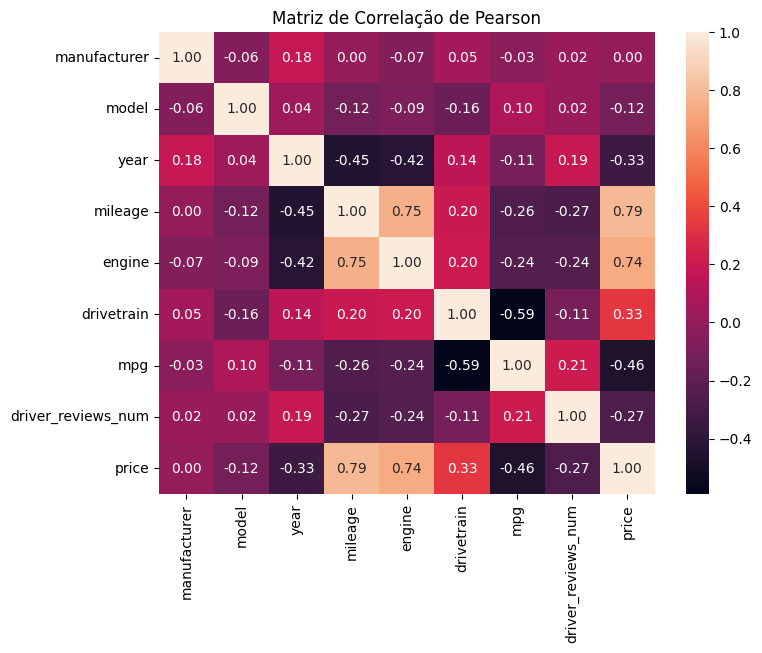

In [97]:
# Plotando com HeatMap as correlações após o Label Encoder
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix_pearson, annot=True, fmt='.2f')
plt.title('Matriz de Correlação de Pearson')
plt.show()

In [98]:
correlation_matrix_spearman = dataframe_corr.corr(method='spearman')

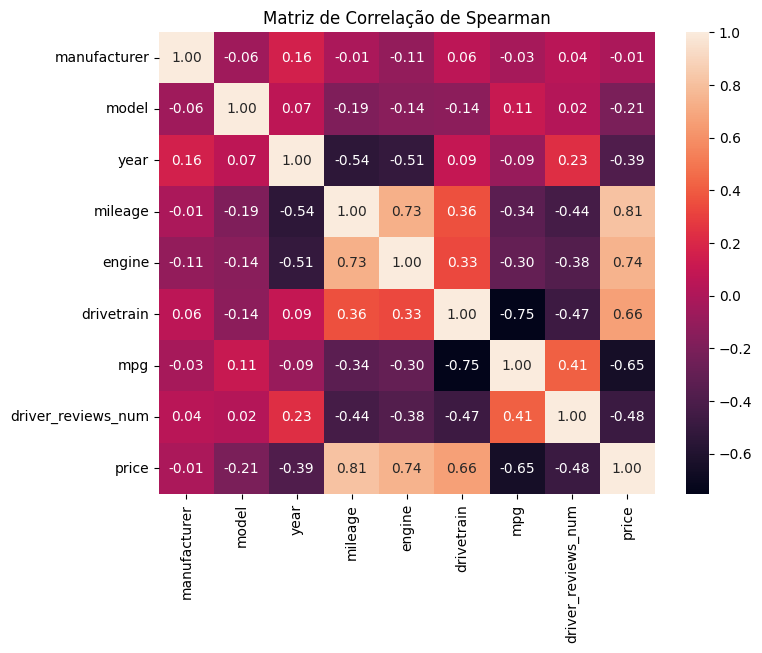

In [99]:
# Plotando com HeatMap as correlações após o Label Encoder
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix_spearman, annot=True, fmt='.2f')
plt.title('Matriz de Correlação de Spearman')
plt.show()

## Divisão dos Dados

Como foi instruído, os dados serão divididos em 70% treino e 30% em teste. Para isso utilizarei o método `train_test_split()`.

In [100]:
X_treinamento, X_teste, y_treinamento, y_teste = train_test_split(X, y, test_size=0.3)

# Criação e Treinamento do Modelo

Após fazer testes com a base de dados, o algoritmo escolhido para criação e treinamento do modelo foi o de **Random Forest**, uma vez que esse algoritmo obteve os melhores resultados.

In [101]:
modelo_rf = RandomForestRegressor(n_estimators=40, max_depth=15)
modelo_rf.fit(X_treinamento, y_treinamento)

RandomForestRegressor(max_depth=15, n_estimators=40)

## Previsões

In [102]:
previsoes = modelo_rf.predict(X_teste)
previsoes

array([77253.08564345, 18733.96919489, 25676.72984834, ...,
       46033.41970229, 19659.85368258, 17945.88225192])

In [103]:
# Valores reais da base de dados
y_teste

array([77500., 20999., 28700., ..., 47990., 16499., 19998.])

# Métricas e Avaliação

In [104]:
score = modelo_rf.score(X_teste, y_teste)

Para avaliar o modelo, escolhi duas métricas sendo elas: Mean Squared Error e Mean Absolute Error.

In [105]:
mse = mean_squared_error(y_teste, previsoes)
mae = mean_absolute_error(y_teste, previsoes)

print(f'Score: {score} \nMAE: {mae} \nMSE: {mse}')

Score: 0.8927212922170357 
MAE: 2811.354222011047 
MSE: 51137539.675026104


A escolha do Mean Absolute Error foi feita por ser uma métrica robusta a outliers e ela não penaliza tanto os erros maiores. O valor dessa métrica indica que o modelo tem uma média de erro de $2.811,35 para cima ou para baixo.

Em compensação, a escolha do Mean Squared Error foi feita para complementar as métricas do MAE, uma vez que esta penaliza os erros maiores. O valor (alto) dessa métrica indica que pode haver erros um pouco maiores nas previsões do modelo, provavelmente devido ao número de outliers.

Outro ponto é o Score, que seria o R², com valor de 0.89 que indica que o modelo desempenha bem, conseguindo explicar mais de 89% da variabilidade nos preços dos carros, ou seja tem um bom ajuste aos dados.

Destarte, a avaliação pessoal do modelo é que ele é um **bom** modelo, que consegue prever bem, pois captura de uma forma positiva (89%) a relação entre a variável objetivo (preço) e as variáveis previsoras. Claro, cabe ainda melhorias no modelo para ele alcançar um nível maior de desempenho.

# Avaliação das Variáveis

In [120]:
# Alternativa para obter os nomes das variáveis no SHAP Values
label_encoder_columns = [base_cars.columns[i] for i in label_encoder_indices]
target_encoder_columns = [base_cars.columns[i] for i in target_encoder_indices]
numerical_columns = [base_cars.columns[i] for i in numerical_indices]

In [121]:
feature_names = label_encoder_columns + target_encoder_columns + numerical_columns

Para encontrar as variáveis mais importantes para o modelo, utilizei uma técnica de XAI chamada Shap Values, essa técnica verifica quais variáveis mais contribuem (positivamente e negativamente) para o modelo.

100%|===================| 53311/53325 [13:13<00:00]        

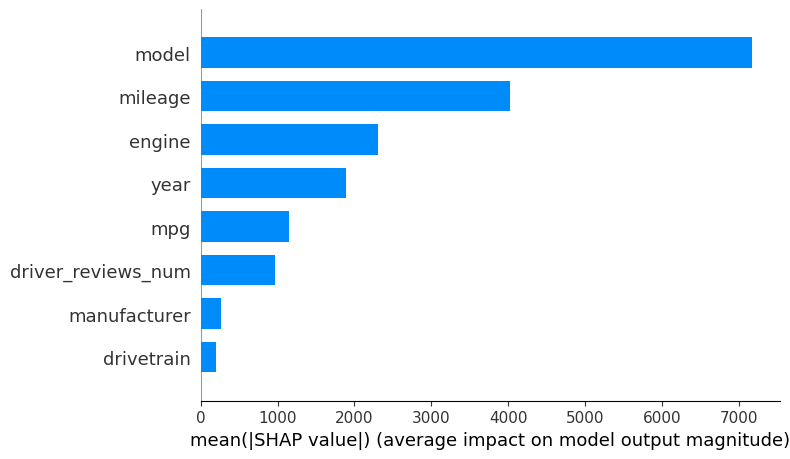

In [122]:
X_treinamento2 = X_treinamento.astype(float)
explainer = shap.Explainer(modelo_rf, X_treinamento2)
shap_values = explainer.shap_values(X_teste)
shap.summary_plot(shap_values, X_teste, feature_names=feature_names, plot_type='bar')

Segundo o Shap Values, as duas variáveis mais importantes para o modelo prever o preço de um carro foram **`model`** e **`mileage`**. Isso faz sentido, uma vez que o modelo do carro está diretamente associado ao valor percebido no mercado, já que determinados modelos são reconhecidos por durarem mais, desempenho ou status, o que influencia significativamente o preço. Por outro lado, a variável mileage também é fundamental, pois a quilometragem de um carro indica seu desgaste e pode sugerir se o veículo terá custos elevados com manutenção no futuro, além de influenciar a percepção sobre sua vida útil restante. Quanto menor a quilometragem, em geral, maior tende a ser o valor do carro.

# Testes com Outros Algoritmos

## Árvores de Decisão

In [106]:
# Criação e treinamento do modelo
modelo_dt = DecisionTreeRegressor()
modelo_dt.fit(X_treinamento, y_treinamento)

DecisionTreeRegressor()

In [107]:
# Previsões
previsoes_dt = modelo_dt.predict(X_teste)
previsoes_dt

array([67997., 20000., 23995., ..., 32995., 19587., 18988.])

In [108]:
# Valores reais
y_teste

array([77500., 20999., 28700., ..., 47990., 16499., 19998.])

In [109]:
# Métricas
score = modelo_dt.score(X_teste, y_teste)
mae = mean_absolute_error(y_teste, previsoes_dt)
mse = mean_squared_error(y_teste, previsoes_dt)

print(f'Score: {score} \nMAE: {mae} \nMSE: {mse}')

Score: 0.8574806628849186 
MAE: 3560.513642756681 
MSE: 67936018.30966714


## Redes Neurais

In [110]:
X_rna = X.copy()

In [111]:
y_rna = y.copy()

In [112]:
y_rna = y_rna.reshape(-1, 1)

In [113]:
# Normalizando os dados
scaler = StandardScaler()
X_rna = scaler.fit_transform(X)
y_scaler = StandardScaler()
y_rna = y_scaler.fit_transform(y_rna)

In [114]:
# Divisão dos dados em treino e teste
X_treinamento_rna, X_teste_rna, y_treinamento_rna, y_teste_rna = train_test_split(X_rna, y_rna, test_size=0.3)

In [115]:
# Criação do modelo
modelo_rna = MLPRegressor(max_iter=1000, hidden_layer_sizes=(10,10))
modelo_rna.fit(X_treinamento_rna, y_treinamento_rna.ravel())

MLPRegressor(hidden_layer_sizes=(10, 10), max_iter=1000)

In [116]:
# Previsões
previsoes_rna = modelo_rna.predict(X_teste_rna)
previsoes_rna

array([-0.16828548, -0.90927533, -0.73333121, ...,  0.30718846,
       -0.60923412, -0.42233371])

In [123]:
inverse_y = y_scaler.inverse_transform(y_teste_rna)
inverse_previsoes = y_scaler.inverse_transform(previsoes_rna.reshape(-1,1))

In [126]:
# Métricas
score = modelo_rna.score(X_teste_rna, y_teste_rna)
mae = mean_absolute_error(inverse_y, inverse_previsoes)
mse = mean_squared_error(inverse_y, inverse_previsoes)

print(f'Score: {score} \nMAE: {mae} \nMSE: {mse}')

Score: 0.8636726533452981 
MAE: 4145.168859345459 
MSE: 60055569.07898992
